# Cyclic Learning Rate and Snapshot Ensembles

Model ensembles can achieve lower generalization errors than single models but are challenging to develop with deep learning neural networks, given the computational cost of training every model. An alternative is to train multiple model snapshots during a single training run and combine their predictions to make an ensemble prediction. A limitation of this approach is that the saved models will be similar, resulting in similar predictions and predictions errors and not offering many benefits from combining their predictions.

Effective ensembles require a diverse set of skillful ensemble members that have different distributions of prediction errors. One approach to promoting a diversity of models saved during a single training run is to use an aggressive learning rate schedule that forces large changes in the model weights and, in turn, the nature of the model saved at each snapshot. In this tutorial, you will discover how to develop snapshot ensembles of models saved using an aggressive learning rate schedule over a single training run. After completing this tutorial, you will know:

* Snapshot ensembles combine the predictions from multiple models saved during a single training run.
* Diversity in model snapshots can be achieved by aggressively cycling the learning rate used during a single training run.
* How to save model snapshots during a single run and load snapshot models to make ensemble predictions.

## Snapshot Ensembles

A problem with ensemble learning with deep learning methods is the large computational cost of training multiple models. This is because of the use of very deep models and large datasets, which can result in model training times extending to days, weeks, or even months.

One approach to ensemble learning for deep learning neural networks is to collect multiple models from a single training run. This addresses the computational cost of training multiple deep learning models as models can be selected and saved during training, then used to make an ensemble prediction. A key benefit of ensemble learning is improved performance compared to the predictions from single models. This can be achieved by selecting members with good skills but in different ways, providing a diverse set of predictions to be combined. A limitation of collecting multiple models during a single training run is that the models may be good but too similar.

This can be addressed by changing the learning algorithm for the deep neural network to explore different network weights during a single training run that will result in models with differing performances. One way that this can be achieved is by aggressively changing the learning rate used during training. An approach to systematically and aggressively changing the learning rate during training to result in very different network weights is referred to as Stochastic Gradient Descent with Warm Restarts or SGDR for short, described by Ilya Loshchilov and Frank Hutter in their 2017 paper *SGDR: Stochastic Gradient Descent with Warm Restarts*.

Their approach involves systematically changing the learning rate over training epochs, called cosine annealing. This approach requires the specification of two hyperparameters: the initial learning rate and the total number of training epochs. The cosine annealing method has the effect of starting with a large learning rate that is relatively rapidly decreased to a minimum value before being dramatically increased again. The model weights are subjected to the dramatic changes during training, having the effect of using good weights as the starting point for the subsequent learning rate cycle but allowing the learning algorithm to converge to a different solution.

The resetting of the learning rate acts as a simulated restart of the learning process, and the re-use of good weights as the starting point of the restart is referred to as a warm restart, in contrast to a cold restart where a new set of small random numbers may be used as a starting point. The good weights at the bottom of each cycle can be saved to file, providing a snapshot of the model. These snapshots can be collected at the end of the run and used in a model averaging ensemble. The saving and use of these models during an aggressive learning rate schedule is referred to as a Snapshot Ensemble and was described by Gao Huang et al. in their 2017 paper titled *Snapshot Ensembles: Train 1, get M for free* and subsequently also used in an updated version of the Loshchilov and Hutter paper.

The ensemble of models is created during training a single model, therefore, the authors claim that the ensemble forecast is provided at no additional cost.

Although a cosine annealing schedule is used for the learning rate, other aggressive learning rate schedules could be used, such as the simpler cyclical learning rate schedule described by Leslie Smith in the 2017 paper titled Cyclical Learning Rates for Training Neural Networks. Now that we are familiar with the snapshot ensemble technique, we can look at how to implement it in Python with Keras.

## Snapshot Ensembles Case Study

In this section, we will demonstrate how to use the snapshot ensemble to reduce the variance of an MLP on a simple multiclass classification problem. This example provides a template for applying the snapshot ensemble to your neural network for classification and regression problems.

### Multiclass Classification Problem

We will use a small multiclass classification problem as the basis to demonstrate the snapshot ensemble. The scikit-learn class provides the `make_blobs()` function that can be used to create a multiclass classification problem with the prescribed number of samples, input variables, classes, and variance of samples within a class. We use this problem with 1,000 examples, with input variables (to represent the x and y coordinates of the points) and a standard deviation of 2.0 for points within each group. We will use the same random state (seed for the pseudorandom number generator) to ensure that we always get the same data points.

In [1]:
from sklearn.datasets import make_blobs

# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

The results are the input and output elements of a dataset that we can model. In order to get a feeling for the complexity of the problem, we can graph each point on a two-dimensional scatter plot and color each point by class value. The complete example is listed below.

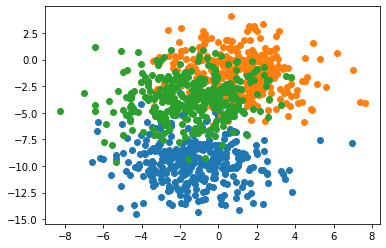

In [2]:
# scatter plot of blobs dataset
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from numpy import where

# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

# scatter plot for each class value
for class_value in range(3):
    # select indices of points with the class label
    row_ix = where(y == class_value)

    # scatter plot for points with a different color
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])

# show plot
pyplot.show()

Running the example creates a scatter plot of the entire dataset. We can see that the standard deviation of 2.0 means that the classes are not linearly separable (separable by a line), causing many ambiguous points. This is desirable because the problem is non-trivial and will allow a neural network model to find many different *good enough* candidate solutions resulting in a high variance. 

### Multilayer Perceptron Model

Before we define a model, we need to contrive an appropriate problem for a horizontal voting ensemble. In our problem, the training dataset is relatively small. Specifically, there is a 10:1 ratio of examples in the training dataset to the holdout dataset. This mimics a situation where we may have a vast number of unlabeled examples and a small number of labeled examples with which to train a model. We will create 1,100 data points from the blobs problem. The model will be trained on the first 100 points, and the remaining 1,000 will be held back in a test dataset, unavailable to the model.

The problem is a multiclass classification problem, and we will model it using a softmax activation function on the output layer. This means that the model will predict a vector with three elements with the probability that the sample belongs to each of the three classes. Therefore, the first step is to one-hot encode the class values.

In [3]:
# scatter plot of blobs dataset
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# one hot encode output variable
y = to_categorical(y)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)

(100, 2) (1000, 2)


Next, we can define and compile the model. The model will expect samples with two input variables. The model then has a single hidden layer with 25 nodes and a rectified linear activation function, an output layer with three nodes to predict the probability of each of the three classes, and a softmax activation function. Because the problem is multiclass, we will use the categorical cross-entropy loss function to optimize the model and stochastic gradient descent with a small learning rate and momentum.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

The model is fit for 200 training epochs, and we will evaluate each epoch on the test set, using the test set as a validation set.

In [6]:
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=1)

Epoch 1/200
4/4 [==============================] - 1s 47ms/step - loss: 1.0706 - accuracy: 0.3657 - val_loss: 0.9721 - val_accuracy: 0.3740
Epoch 2/200
4/4 [==============================] - 0s 16ms/step - loss: 0.9163 - accuracy: 0.4138 - val_loss: 0.9158 - val_accuracy: 0.4850
Epoch 3/200
4/4 [==============================] - 0s 17ms/step - loss: 0.8915 - accuracy: 0.4798 - val_loss: 0.8567 - val_accuracy: 0.5450
Epoch 4/200
4/4 [==============================] - 0s 18ms/step - loss: 0.7999 - accuracy: 0.6520 - val_loss: 0.8133 - val_accuracy: 0.6190
Epoch 5/200
4/4 [==============================] - 0s 15ms/step - loss: 0.7866 - accuracy: 0.6381 - val_loss: 0.7680 - val_accuracy: 0.6660
Epoch 6/200
4/4 [==============================] - 0s 16ms/step - loss: 0.7271 - accuracy: 0.6696 - val_loss: 0.7582 - val_accuracy: 0.6720
Epoch 7/200
4/4 [==============================] - 0s 15ms/step - loss: 0.6504 - accuracy: 0.7359 - val_loss: 0.7354 - val_accuracy: 0.6760
Epoch 8/200
4/4 [===

4/4 [==============================] - 0s 16ms/step - loss: 0.3547 - accuracy: 0.8310 - val_loss: 0.5559 - val_accuracy: 0.7680
Epoch 118/200
4/4 [==============================] - 0s 15ms/step - loss: 0.4221 - accuracy: 0.8200 - val_loss: 0.4923 - val_accuracy: 0.7870
Epoch 119/200
4/4 [==============================] - 0s 15ms/step - loss: 0.3721 - accuracy: 0.7981 - val_loss: 0.4558 - val_accuracy: 0.8000
Epoch 120/200
4/4 [==============================] - 0s 16ms/step - loss: 0.3529 - accuracy: 0.8332 - val_loss: 0.4445 - val_accuracy: 0.7970
Epoch 121/200
4/4 [==============================] - 0s 15ms/step - loss: 0.3413 - accuracy: 0.8157 - val_loss: 0.4483 - val_accuracy: 0.8050
Epoch 122/200
4/4 [==============================] - 0s 15ms/step - loss: 0.3465 - accuracy: 0.8219 - val_loss: 0.4417 - val_accuracy: 0.8090
Epoch 123/200
4/4 [==============================] - 0s 15ms/step - loss: 0.3257 - accuracy: 0.8506 - val_loss: 0.4376 - val_accuracy: 0.8200
Epoch 124/200
4/4 [=

Epoch 175/200
4/4 [==============================] - 0s 16ms/step - loss: 0.3795 - accuracy: 0.8065 - val_loss: 0.4790 - val_accuracy: 0.8060
Epoch 176/200
4/4 [==============================] - 0s 16ms/step - loss: 0.4088 - accuracy: 0.7967 - val_loss: 0.4634 - val_accuracy: 0.8070
Epoch 177/200
4/4 [==============================] - 0s 17ms/step - loss: 0.3462 - accuracy: 0.8363 - val_loss: 0.4911 - val_accuracy: 0.7980
Epoch 178/200
4/4 [==============================] - 0s 16ms/step - loss: 0.3388 - accuracy: 0.8270 - val_loss: 0.4595 - val_accuracy: 0.8090
Epoch 179/200
4/4 [==============================] - 0s 15ms/step - loss: 0.3124 - accuracy: 0.8280 - val_loss: 0.4419 - val_accuracy: 0.8100
Epoch 180/200
4/4 [==============================] - 0s 16ms/step - loss: 0.3624 - accuracy: 0.8183 - val_loss: 0.4411 - val_accuracy: 0.8090
Epoch 181/200
4/4 [==============================] - 0s 15ms/step - loss: 0.3250 - accuracy: 0.8360 - val_loss: 0.4497 - val_accuracy: 0.8040
Epoch 

At the end of the run, we will evaluate the model's performance on both the train and the test sets.

In [7]:
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.810, Test: 0.828


Then finally, we will plot model loss and accuracy learning curves over each training epoch on both the training and test dataset.

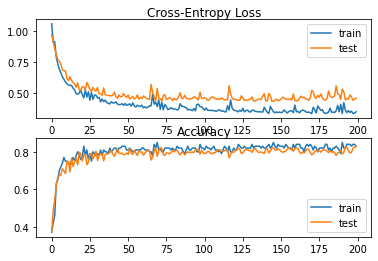

In [8]:
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()

pyplot.show()

The complete example is listed below.

In [9]:
# develop an mlp for blobs dataset
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# one hot encode output variable
y = to_categorical(y)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.830, Test: 0.793


Running the example, it first prints the performance of the final model on the train and test datasets.

**Note:** Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

In this case, we can see that the model achieved about 83% accuracy on the training dataset, which we know is optimistic, and about 79% on the test dataset, which we would expect to be more realistic.

A line plot also shows the learning curves for the model accuracy on the train and test sets over each training epoch. We can see that training accuracy is more optimistic over the whole run, as we noted with the final scores.

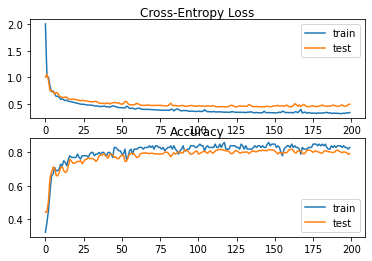

In [10]:
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()

pyplot.show()

Next, we can look at how to implement an aggressive learning rate schedule.

### Cosine Annealing Learning Rate

An effective snapshot ensemble requires training a neural network with an aggressive learning rate schedule. The cosine annealing schedule is an example of an aggressive learning rate schedule where the learning rate starts high and is dropped relatively rapidly to a minimum value near zero before being increased again to the maximum. We can implement the schedule described in the 2017 paper "Snapshot Ensembles: Train 1, get M for free". The equation requires the total training epochs, maximum learning rate, number of cycles as arguments, and the current epoch number. The function then returns the learning rate for the given epoch.

<h2><center>$ \alpha(t) = \frac{\alpha_0}{2}(cos(\frac{\pi mod(t-1, \lfloor{T/M}\rfloor)}{\lfloor{T/M}\rfloor})+1) $</center></h2>

Where `a(t)` is the learning rate at epoch `t,` `a0` is the maximum learning rate, `T` is the total epochs, M is the number of cycles, `mod` is the modulo operation, and square brackets indicate a floor operation. The function `cosine_annealing()` below implements the equation.

In [1]:
# cosine annealing learning rate schedule
def cosine_annealing(epoch, n_epochs, n_cycles, lrate_max):
    epochs_per_cycle = floor(n_epochs/n_cycles)
    cos_inner = (pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
    
    return lrate_max/2 * (cos(cos_inner) + 1)

We can test this implementation by plotting the learning rate over 100 epochs with five cycles (e.g., 20 epochs long) and a maximum learning rate of 0.01. The complete example is listed below.

In [2]:
# example of a cosine annealing learning rate schedule
from matplotlib import pyplot
from math import pi
from math import cos
from math import floor

# cosine annealing learning rate schedule
def cosine_annealing(epoch, n_epochs, n_cycles, lrate_max):
    epochs_per_cycle = floor(n_epochs/n_cycles)
    cos_inner = (pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
    
    return lrate_max/2 * (cos(cos_inner) + 1)

# create learning rate series
n_epochs = 100
n_cycles = 5
lrate_max = 0.01
series = [cosine_annealing(i, n_epochs, n_cycles, lrate_max) for i in range(n_epochs)]

Running the example creates a line plot of the learning rate schedule over 100 epochs. We can see that the learning rate starts at the maximum value at epoch 0 and decreases rapidly to epoch 19 before being reset at epoch 20, the start of the next cycle. The cycle is repeated five times as specified in the argument.

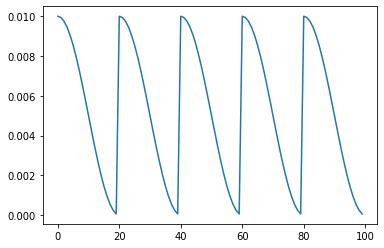

In [3]:
# plot series
pyplot.plot(series)
pyplot.show()

We can implement this schedule as a custom callback in Keras. This allows the schedule parameters to be specified and for the learning rate to be logged so we can ensure it had the desired effect. A custom callback can be defined as a Python class that extends the Keras Callback class. In the class constructor, we can take the required configuration as arguments and save them for use, specifically the total number of training epochs, the number of cycles for the learning rate schedule, and the maximum learning rate. We can use our `cosine_annealing()` defined above to calculate the learning rate for a given training epoch. The Callback class allows an `on_epoch_begin()` function to be overridden that will be called prior to each training epoch. We can override this function to calculate the learning rate for the current epoch and set it in the optimizer. We can also keep track of the learning rate in an internal list. The complete custom callback is defined below.

In [5]:
from tensorflow.keras.callbacks import Callback

# define custom learning rate schedule
class CosineAnnealingLearningRateSchedule(Callback):
    # constructor
    def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
        self.epochs = n_epochs
        self.cycles = n_cycles
        self.lr_max = lrate_max
        self.lrates = list()

    # calculate learning rate for an epoch
    def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
        epochs_per_cycle = floor(n_epochs/n_cycles)
        cos_inner = (pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
        
        return lrate_max/2 * (cos(cos_inner) + 1)

    # calculate and set learning rate at the start of the epoch
    def on_epoch_begin(self, epoch, logs=None):
        # calculate learning rate
        lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)

        # set learning rate
        backend.set_value(self.model.optimizer.lr, lr)
        
        # log value
        self.lrates.append(lr)

We can create an instance of the callback and set the arguments. We will train the model for 400 epochs and set the number of cycles to be 50 epochs long, or 400/50 cycles, a suggestion made and configuration used throughout the snapshot ensembles paper.

The paper also suggests that the learning rate can be set for each sample or minibatch instead of each epoch to give more nuance to the updates, but we will leave this as a future exercise.

Once the callback is instantiated and configured, we can specify it as part of the list of callbacks to the call to the `fit()` function to train the model.

```
# define learning rate callback
n_epochs = 400
n_cycles = n_epochs / 50
ca = CosineAnnealingLearningRateSchedule(n_epochs, n_cycles, 0.01)

# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=n_epochs, verbose=0, callbacks=[ca])
```

At the end of the run, we can confirm that the learning rate schedule was performed by plotting the contents of the `lrates` list.

```
# plot learning rate
pyplot.plot(ca.lrates)
pyplot.show()
```

Tying these elements together, the complete example of training an MLP on the blobs problem with a cosine annealing learning rate schedule is listed below.

In [13]:
# mlp with cosine annealing learning rate schedule on blobs problem
from sklearn.datasets import make_blobs

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend

from math import pi, cos, floor
from matplotlib import pyplot

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# one hot encode output variable
y = to_categorical(y)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
opt = SGD(momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# define learning rate callback
n_epochs = 400
n_cycles = n_epochs / 50
ca = CosineAnnealingLearningRateSchedule(n_epochs, n_cycles, 0.01)

# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=n_epochs, verbose=0, callbacks=[ca])

Running the example first reports the accuracy of the model on the training and test sets.

**Note:** Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

In this case, we do not see much difference in the final model's performance compared to the previous section.

In [14]:
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.850, Test: 0.816


A line plot of the learning rate schedule is created, showing eight cycles of 50 epochs each.

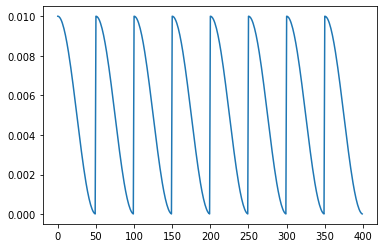

In [15]:
# plot learning rate
pyplot.plot(ca.lrates)
pyplot.show()

Finally, a line plot of model loss and accuracy on the train and test sets is created over each training epoch. We can see that although the learning rate was changed dramatically, there was not a dramatic effect on model performance, likely because the chosen classification problem is not very difficult.

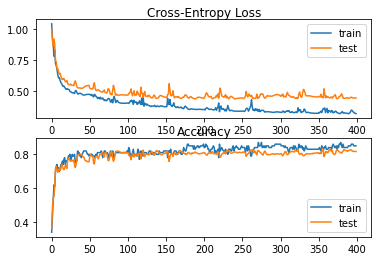

In [16]:
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

Now that we know how to implement the cosine annealing learning schedule, we can use it to prepare a snapshot ensemble.

### MLP Snapshot Ensemble

We can develop a snapshot ensemble in two parts. The first part involves creating a custom callback to save the model at the bottom of each learning rate schedule. The second part involves loading the saved models and using them to make an ensemble prediction.

**Save Snapshot Models During Training**

The `CosineAnnealingLearningRateSchedule` can be updated to override the on epoch end() function called at the end of each training epoch. In this function, we can check if the current epoch that ended was the end of a cycle. If so, we can save the model to a file. Below is the updated callback, named the `SnapshotEnsemble` class. A debug message is printed each time a model is saved as confirmation that models are being saved at the right time. For example, with 50-epoch long cycles, we would expect a model to be saved on epoch 49, 99, etc., and the learning rate reset at epoch 50, 100, etc.

In [12]:
# snapshot ensemble with custom learning rate schedule
class SnapshotEnsemble(Callback):
    # constructor
    def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
        self.epochs = n_epochs
        self.cycles = n_cycles
        self.lr_max = lrate_max
        self.lrates = list()

    # calculate learning rate for epoch
    def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
        epochs_per_cycle = floor(n_epochs/n_cycles)
        cos_inner = (pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
        
        return lrate_max/2 * (cos(cos_inner) + 1)

    # calculate and set learning rate at the start of the epoch
    def on_epoch_begin(self, epoch, logs={}):
        # calculate learning rate
        lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)

        # set learning rate
        backend.set_value(self.model.optimizer.lr, lr)

        # log value
        self.lrates.append(lr)

    # save models at the end of each cycle
    def on_epoch_end(self, epoch, logs={}):
        # check if we can save model
        epochs_per_cycle = floor(self.epochs / self.cycles)
        
        if epoch != 0 and (epoch + 1) % epochs_per_cycle == 0:
            # save model to file
            filename = "snapshot_model_%d.h5" % int((epoch + 1) / epochs_per_cycle)
            self.model.save(filename)
            print('>saved snapshot %s, epoch %d' % (filename, epoch))

We will train the model for 500 epochs to give ten models to choose from later in an ensemble prediction. The complete example of using this new snapshot ensemble to save models to a file is listed below.

In [17]:
# example of saving models for a snapshot ensemble
from sklearn.datasets import make_blobs

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend

from math import pi, cos, floor
from matplotlib import pyplot

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# one hot encode output variable
y = to_categorical(y)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(50, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
opt = SGD(momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# create snapshot ensemble callback
n_epochs = 500
n_cycles = n_epochs / 50
ca = SnapshotEnsemble(n_epochs, n_cycles, 0.01)

Running the example reports that ten models were saved for the 10-ends of the cosine annealing learning rate schedule.

In [18]:
# fit model
model.fit(trainX, trainy, validation_data=(testX, testy), epochs=n_epochs, verbose=0, callbacks=[ca])

>saved snapshot snapshot_model_1.h5, epoch 49
>saved snapshot snapshot_model_2.h5, epoch 99
>saved snapshot snapshot_model_3.h5, epoch 149
>saved snapshot snapshot_model_4.h5, epoch 199
>saved snapshot snapshot_model_5.h5, epoch 249
>saved snapshot snapshot_model_6.h5, epoch 299
>saved snapshot snapshot_model_7.h5, epoch 349
>saved snapshot snapshot_model_8.h5, epoch 399
>saved snapshot snapshot_model_9.h5, epoch 449
>saved snapshot snapshot_model_10.h5, epoch 499


**Load Models and Make Ensemble Prediction**

Once the snapshot models have been saved to file, they can be loaded and used to make an ensemble prediction. The first step is to load the models into memory. For large models, this could be done one model at a time, make a prediction, and move on to the next model before combining predictions. In this case, the models are relatively small, and we can load all ten from le as a list.

In [19]:
# load models from file
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = 'snapshot_model_' + str(i + 1) + '.h5'
        
        # load model from file
        model = load_model(filename)

        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    
    return all_models

We would expect that models saved towards the end of the run may have better performance than models saved earlier in the run. As such, we can reverse the list of loaded models so that the older models are first.

```
# reverse loaded models so we build the ensemble with the last models first
members = list(reversed(members))
```

We don't know how many snapshots are required to make a good prediction for this problem. We can explore the effect of the number of ensemble members on test set accuracy by creating ensembles of increasing size starting with the final model at epoch 499, then adding the model saved at epoch 449, and so on until all ten models are included. First, we require a function to make a prediction given a list of models. Given that each model predicts the probabilities of each of the output classes, we can sum the predicted probabilities across the models and select the class with the most support via the `argmax()` function. The `ensemble_predictions()` function below implements this functionality.

In [21]:
# make an ensemble prediction for multiclass classification
def ensemble_predictions(members, testX):
    # make predictions
    yhats = [model.predict(testX) for model in members]
    yhats = array(yhats)

    # sum across ensemble members
    summed = numpy.sum(yhats, axis=0)

    # argmax across classes
    result = argmax(summed, axis=1)

    return result

We can then evaluate an ensemble of a given size by selecting the first `n` members from the list of models, making a prediction by calling the `ensemble_predictions()` function, and then calculating and returning the accuracy of the prediction. The `evaluate_n_members()` function below implements this behavior.

In [22]:
# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
    # select a subset of members
    subset = members[:n_members]

    # make prediction
    yhat = ensemble_predictions(subset, testX)

    # calculate accuracy
    return accuracy_score(testy, yhat)

Each ensemble's performance can also be contrasted with the performance of each standalone model and the average performance of all standalone models.

```
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, len(members)+1):
    # evaluate model with i members
    ensemble_score = evaluate_n_members(members, i, testX, testy)
    
    # evaluate the i'th model standalone
    testy_enc = to_categorical(testy)
    _, single_score = members[i-1].evaluate(testX, testy_enc, verbose=0)

    # summarize this step
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
    ensemble_scores.append(ensemble_score)
    single_scores.append(single_score)

# summarize average accuracy of a single final model
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))
```

Finally, we can plot each snapshot model (blue dots) compared to the performance of an ensemble that includes all models up to and including each model (orange line).

```
# plot score vs number of ensemble members
x_axis = [i for i in range(1, len(members)+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()
```

The complete example of making snapshot ensemble predictions with different sized ensembles is listed below.

In [25]:
# load models and make a snapshot ensemble prediction
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

from numpy import mean, std, array, argmax
import numpy
from matplotlib import pyplot

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

Running the example first loads all ten models into memory.

In [26]:
# load models in order
members = load_all_models(10)
print('Loaded %d models' % len(members))

# reverse loaded models so we build the ensemble with the last models first
members = list(reversed(members))

>loaded snapshot_model_1.h5
>loaded snapshot_model_2.h5
>loaded snapshot_model_3.h5
>loaded snapshot_model_4.h5
>loaded snapshot_model_5.h5
>loaded snapshot_model_6.h5
>loaded snapshot_model_7.h5
>loaded snapshot_model_8.h5
>loaded snapshot_model_9.h5
>loaded snapshot_model_10.h5
Loaded 10 models


Next, each snapshot model is evaluated on the test dataset, and the accuracy is reported. This is contrasted with the accuracy of a snapshot ensemble that includes all snapshot models working backward from the end of the run, including the single model. The results show that as we work backward from the end of the run, the performance of the snapshot models gets worse, as we might expect.

Combining snapshot models into an ensemble shows that performance increases up to and including the last 3-to-5 models, reaching about 82%. This can be compared to the average performance of a snapshot model of about 80% test set accuracy.

**Note:** Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

In [27]:
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, len(members)+1):
    # evaluate model with i members
    ensemble_score = evaluate_n_members(members, i, testX, testy)
    
    # evaluate the i'th model standalone
    testy_enc = to_categorical(testy)
    _, single_score = members[i-1].evaluate(testX, testy_enc, verbose=0)
    
    # summarize this step
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
    ensemble_scores.append(ensemble_score)
    single_scores.append(single_score)

# summarize average accuracy of a single final model
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))

> 1: single=0.807, ensemble=0.807
> 2: single=0.817, ensemble=0.811
> 3: single=0.805, ensemble=0.810
> 4: single=0.807, ensemble=0.809
> 5: single=0.807, ensemble=0.810
> 6: single=0.813, ensemble=0.811
> 7: single=0.812, ensemble=0.809
> 8: single=0.801, ensemble=0.809
> 9: single=0.802, ensemble=0.807
> 10: single=0.790, ensemble=0.809
Accuracy 0.806 (0.007)


Finally, a line plot is created, plotting the same test set accuracy scores. We can set the performance of each snapshot model as a blue dot and the snapshot ensemble of increasing size (number of members) from 1 to 10 members as an orange line. At least on this run, we can see that the snapshot ensemble quickly out-performs the final model at 82.2% with three members and all other saved models before performance degrades back down to about the same as the final model at 81.3%.

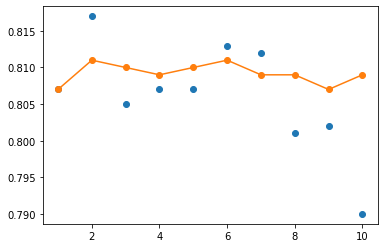

In [28]:
# plot score vs number of ensemble members
x_axis = [i for i in range(1, len(members)+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

## Extensions

Extensions This section lists some ideas for extending the tutorial that you may wish to explore.

* **Vary Cycle Length**. Update the example to use a shorter or longer cycle length and compare results.
* **Vary Maximum Learning Rate**. Update the example to use a larger or smaller maximum learning rate and compare results.
* **Update Learning Rate Per Batch**. Update the example to calculate the learning rate per batch instead of per-epoch.
* **Repeated Evaluation**. Update the example to repeat the evaluation of the model to confirm that the approach indeed leads to improved performance over the final model on the blobs problem.
* **Cyclic Learning Rate**. Update the example to use a cyclic learning rate schedule and compare results.

## Summary

This tutorial taught you to develop snapshot ensembles of models saved using an aggressive learning rate schedule over a single training run. Specifically, you learned:

* Snapshot ensembles combine the predictions from multiple models saved during a single training run.
* Diversity in model snapshots can be achieved by aggressively cycling the learning rate used during a single training run.
* How to save model snapshots during a single run and load snapshot models to make ensemble predictions.